# Internal Resistance Calculation for Small Vertical Axis Wind Turbine
**Author:** Ian Eykamp, **Date:** 6/16/2023

## Purpose
I powered the wind turbine using the wind tunnel in the 4th floor Rocketry lab. I repeated calculations used to find the internal resistance of the generator.

The wind tunnel has a power setting from 0-80 that corresponds to how fast (in Hz) the fan inside the wind tunnel is spinning. So it doesn't really correlate with an actual wind speed felt by the turbine. There is a table that correlates the speed setting to wind speed, but this means wind speed inside the tunnel, which is different and much lower at the outlet, especially as it diffuses into the open space. The first set of measurements is taken at a setting of 20 out of 80; for the later measurements, I set it to either 30 or 39 out of 80, because that was as fast as I felt comfortable letting the wind turbine spin safely.

### Import libraries
`plecs_helper.py` is a file I created which defines some helper functions for nice plots and getting data off the oscilloscope and out of PLECS.

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

import warnings
warnings.filterwarnings("ignore", message="some peaks have a width of 0") # get rid of an annoying warning printout

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

def generator_hz_to_rpm(hz):
    # the generator probably has multiple poles, which means it will exhibit one full period of the sine wave
    # while only making 1 / n_poles of a rotation.
    n_poles = 3 # I don't know whether n_poles = 2 or 3
    return hz * 60 / n_poles

Using matplotlib backend: TkAgg


## Experiment 1: With respect to load resistance

I connected the oscilloscope leads between two terminals of the generator (the third terminal was left dangling).

I captured one dataset with no load, and three further datasets at 100Ohm, 6.8Ohm, and (6.8 || (6.8 + 6.8)) Ohm loads between the terminals I was measuring. I did not write it down, and sadly, I don't know what wind speed setting the wind tunnel was operating at. My best guess is a fan speed of 20Hz.

The peak voltage $V_{peak}$ available from the 3-phase generator is equal to the greatest instantaneous difference between any two phases. Here, it is the maximum peak-to-trough voltage. This is two times the amplitude of the wave. The RMS voltage for the 3-phase generator is $V_{RMS} = \frac{V_{peak}}{\sqrt{3}}$. I calculated the frequency by looking at the spacing of the peaks.

With no load, the generator had an amplitude of 17.19V and a frequency of 5.172Hz; hence 103 RPM
With a 100ohm load, the generator had an amplitude of 14.49V and a frequency of 4.942Hz; hence 99 RPM
With a 6.8ohm load, the generator had an amplitude of 4.76V and a frequency of 4.257Hz; hence 85 RPM
With a 4.5ohm load, the generator had an amplitude of 3.38V and a frequency of 4.062Hz; hence 81 RPM


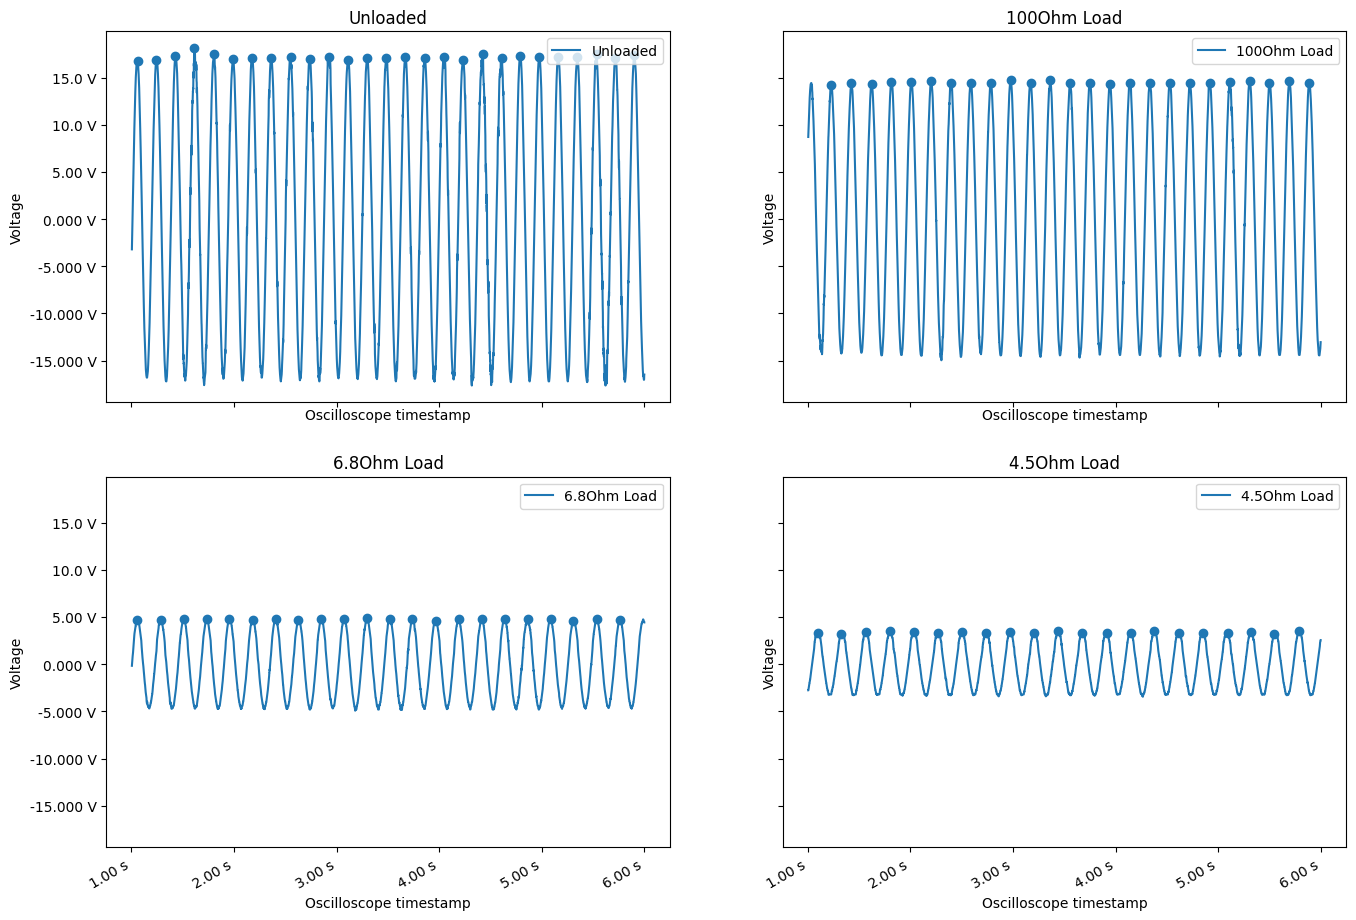

In [178]:
# Import data
# (df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile1.csv", ch1 = "6.8Ohm_Delta")
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile2.csv", ch1 = "4.5Ohm") # ch1 = "4.5Ohm")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile3.csv", ch1 = "100Ohm") # ch1 = "100Ohm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile4.csv", ch1 = "6.8Ohm") # ch1 = "6.8Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile5.csv", ch1 = "unloaded") # ch1 = "unloaded")
# (df_6, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile6.csv", ch1 = "100Ohm_30Hz")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
# print(df.head(20))

df_zoom = df[(df["t"] > 1) & (df["t"] < 6)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (16, 12))
fig.autofmt_xdate()

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["unloaded", "100Ohm", "6.8Ohm", "4.5Ohm"]
label_list = ["Unloaded", "100Ohm Load", "6.8Ohm Load", "4.5Ohm Load"]

frequencies = []
amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)

    # find peaks for frequency and envelope amplitude analysis
    peak_idx = find_peaks(df_zoom[channel], distance = 100, width = 75)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]

    # find frequency using time difference between peaks
    frequency_points = np.hstack((0, 1 / (np.diff(df_peak_trace["t"]))))
    mean_freq = np.mean(frequency_points)
    frequencies.append(mean_freq)
    amplitude_points = df_peak_trace[channel]
    mean_amplitude = np.mean(amplitude_points)
    amplitudes.append(mean_amplitude)

    # print(frequencies)

    # plot data with peaks
    ax.plot(df_zoom["t"], df_zoom[channel], label = label)
    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    ax.legend(loc = "upper right")

    print(f"With {('no load' if label == 'Unloaded' else 'a ' + label).lower()}, the generator had an amplitude of {mean_amplitude:.2f}V and a frequency of {mean_freq:.3f}Hz; hence {generator_hz_to_rpm(mean_freq):.0f} RPM")


I calcualted the internal resistance $R_1$ using the following equation, based on the load resistor I was using: $R1 = R2 \cdot (\frac{V_{in}}{V_{out}} - 1)$, where $V_{in}$ is the unloaded amplitude and $V_{out}$ is the amplitude given a load resistor of $R_2$.

The input (unloaded generator) voltage is proportional to the frequency of rotation. Hence, we correct input voltage for calculation with test case $i$ by using $V_{in, i} = V_{in, 0} \cdot \frac{f_i}{f_0}$. After correcting for frequency, the calculated internal resistance values get a lot closer together.

The internal resistance of the generator is approximately $13.5 \Omega \pm 0.2 \Omega$.

In [179]:
# always run the previous cell before re-running this cell
# otherwise, you will get bogus numbers, 
# because the subsequent cell overwrites some of the variables used here.

def calculate_R1(Vin, Vout, R2):
    R1 = R2 * (Vin / Vout - 1)
    return R1

unloaded_amplitude = amplitudes[0]
unloaded_frequency = frequencies[0]

print("Three different calculations for internal resistance:")
# print("Before correcting for frequency")
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[1] * units.volt, 100 * units.ohm))
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[2] * units.volt, 6.8 * units.ohm))
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[3] * units.volt, 1/(1/6.8 + 1/(2 * 6.8)) * units.ohm))
# print("")
print("After correcting for frequency")
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[1] / unloaded_frequency, amplitudes[1] * units.volt, 100 * units.ohm))
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[2] / unloaded_frequency, amplitudes[2] * units.volt, 6.8 * units.ohm))
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[3] / unloaded_frequency, amplitudes[3] * units.volt, 1/(1/6.8 + 1/(2 * 6.8)) * units.ohm))
print("")
print(f"Maximum internal power dissipation when short circuited = {((max(amplitudes) * units.volt) ** 2 / (13.5 * units.ohm)).to_compact(units.watt)}")

Three different calculations for internal resistance:
After correcting for frequency
R1 = 13.41 Ω
R1 = 13.42 Ω
R1 = 13.61 Ω

Maximum internal power dissipation when short circuited = 21.90 W


## Experiment 2: With respect to wind speed and load resistance

At test settings of [100Ohm, 30Hz], the generator had an amplitude of 22.79V and a frequency of 8.137Hz; hence 163 RPM
At test settings of [100Ohm, 39Hz], the generator had an amplitude of 30.19V and a frequency of 10.743Hz; hence 215 RPM
At test settings of [6.8Ohm, 30Hz], the generator had an amplitude of 7.63V and a frequency of 7.318Hz; hence 146 RPM
At test settings of [6.8Ohm, 39Hz], the generator had an amplitude of 10.71V and a frequency of 10.447Hz; hence 209 RPM


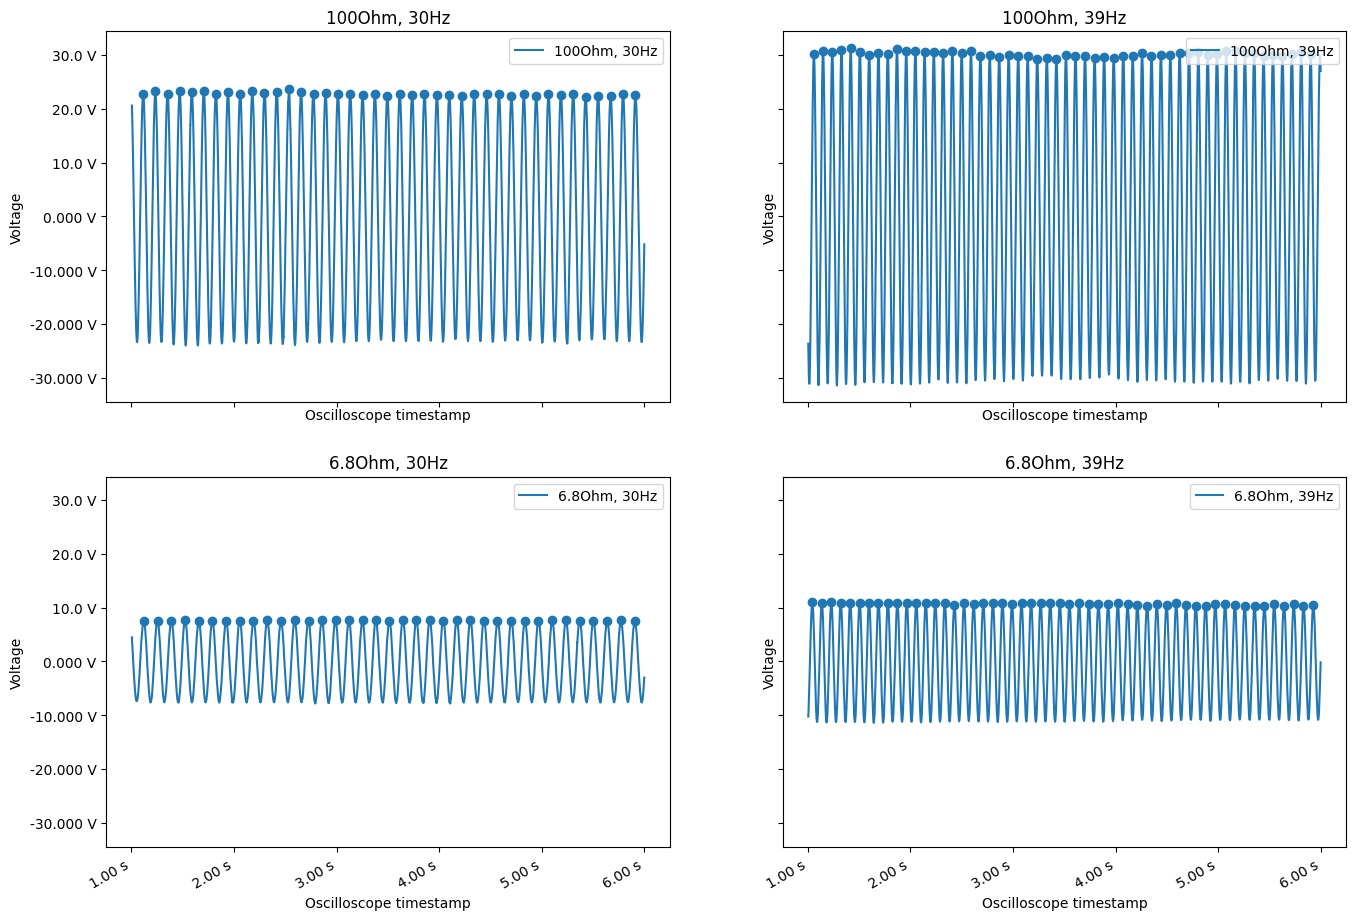

In [180]:
# Import data
# (df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile1.csv", ch1 = "6.8Ohm_Delta")
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile1.csv", ch1 = "100Ohm, 30Hz") # ch1 = "6.8Ohm, 39Hz")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile2.csv", ch1 = "100Ohm, 39Hz") # ch1 = "100Ohm, 39Hz")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile3.csv", ch1 = "6.8Ohm, 30Hz") # ch1 = "6.8Ohm, 30Hz")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile4.csv", ch1 = "6.8Ohm, 39Hz") # ch1 = "100Ohm, 30Hz")
# (df_6, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile6.csv", ch1 = "100Ohm_30Hz")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
# print(df.head(20))

df_zoom = df[(df["t"] > 1) & (df["t"] < 6)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (16, 12))
fig.autofmt_xdate()

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["100Ohm, 30Hz", "100Ohm, 39Hz", "6.8Ohm, 30Hz", "6.8Ohm, 39Hz"]
label_list = ["100Ohm, 30Hz", "100Ohm, 39Hz", "6.8Ohm, 30Hz", "6.8Ohm, 39Hz"]

frequencies = []
amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)

    # find peaks for frequency and envelope amplitude analysis
    peak_idx = find_peaks(df_zoom[channel], distance = 50, width = 50)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]

    # find frequency using time difference between peaks
    frequency_points = np.hstack((0, 1 / (np.diff(df_peak_trace["t"]))))
    mean_freq = np.mean(frequency_points)
    frequencies.append(mean_freq)
    amplitude_points = df_peak_trace[channel]
    mean_amplitude = np.mean(amplitude_points)
    amplitudes.append(mean_amplitude)

    # print(frequencies)

    # plot data with peaks
    ax.plot(df_zoom["t"], df_zoom[channel], label = label)
    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    ax.legend(loc = "upper right")

    print(f"At test settings of [{label}], the generator had an amplitude of {mean_amplitude:.2f}V and a frequency of {mean_freq:.3f}Hz; hence {generator_hz_to_rpm(mean_freq):.0f} RPM")

This is mostly just fun to see how much voltage we can get out of the generator at higher wind speeds. I did not feel like we could safely increase the wind speed much more before making our test stand dangerous. In the unloaded case, we can easily get 30V peak-to-center out of the generator for testing purposes.

Once again, we can repeat the internal resistance calculations and get similar values within $\pm 5\Omega$ of the previous values. Keep in mind that the internal impedance of the generator may be dependent on frequency.

In [181]:
print("Four more calculations for internal resistance:")
# print("Before correcting for frequency")
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[0] * units.volt, 100 * units.ohm))
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[1] * units.volt, 100 * units.ohm))
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[2] * units.volt, 6.8 * units.ohm))
# print("R1 =", calculate_R1(unloaded_amplitude * units.volt, amplitudes[3] * units.volt, 6.8 * units.ohm))
# print("")
print("After correcting for frequency")
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[0] / unloaded_frequency, amplitudes[0] * units.volt, 100 * units.ohm))
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[1] / unloaded_frequency, amplitudes[1] * units.volt, 100 * units.ohm))
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[2] / unloaded_frequency, amplitudes[2] * units.volt, 6.8 * units.ohm))
print("R1 =", calculate_R1(unloaded_amplitude * units.volt * frequencies[3] / unloaded_frequency, amplitudes[3] * units.volt, 6.8 * units.ohm))
print("")
print(f"Maximum internal power dissipation when short circuited = {((max(amplitudes) * units.volt) ** 2 / (13.5 * units.ohm)).to_compact(units.watt)}")

Four more calculations for internal resistance:
After correcting for frequency
R1 = 18.69 Ω
R1 = 18.31 Ω
R1 = 14.88 Ω
R1 = 15.25 Ω

Maximum internal power dissipation when short circuited = 67.50 W
